HPA_KF
POTデータの範囲 22.5 ~ 35.22
最大尤度: 4.0540034946493376e-101
最尤推定 ξ: -0.3524030408452523 σ: 5.189362769394959 RV: 34.94905961349019
RV： [33.37995516435112, 34.94905961349019, 43.10365924477607]
HFA_KF_c0
POTデータの範囲 23.21 ~ 35.11
最大尤度: 5.387565848371936e-104
最尤推定 ξ: -0.6229867285143671 σ: 7.801050208061217 RV: 35.270338090204156
RV： [34.50772988025471, 35.270338090204156, 40.538994523641904]
HPA_YS
POTデータの範囲 18.96 ~ 29.44
最大尤度: 9.115404495903882e-101
最尤推定 ξ: -0.6345831722716149 σ: 6.856517596215709 RV: 29.39013016181972
RV： [28.806004970485944, 29.39013016181972, 32.44131763616628]
HFA_YS_c0
POTデータの範囲 17.99 ~ 31.85
最大尤度: 8.779501542337536e-105
最尤推定 ξ: -0.45161705965726107 σ: 6.807869307612408 RV: 31.68663435159981
RV： [30.40079975540538, 31.68663435159981, 38.56889434993824]


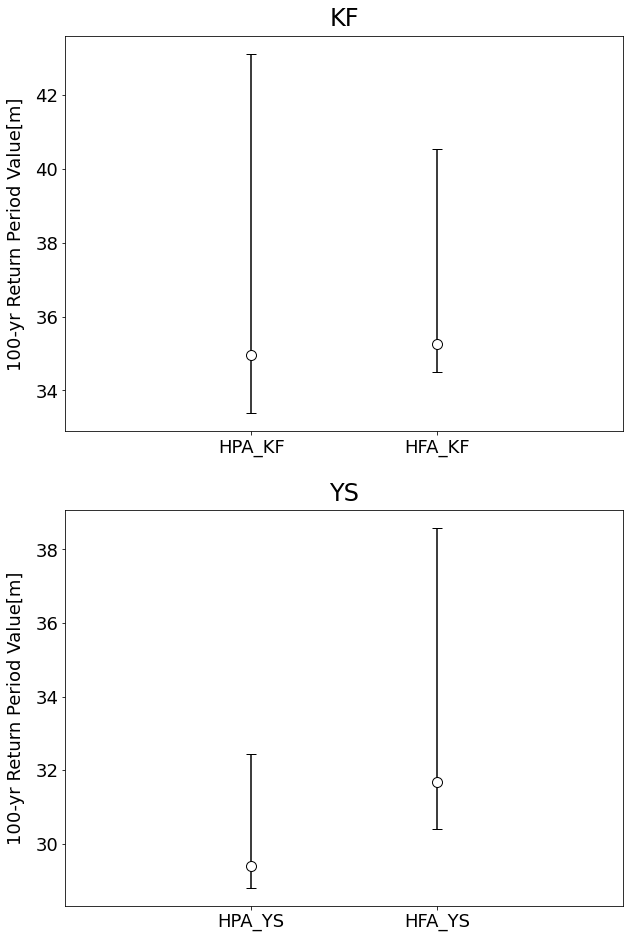

In [2]:
"""
それぞれのモデルのイベントごとの空間最大値を算出する.
それらの上位DATA_CNT個の点に対して, 極値統計解析を行い, 現在と過去で比較する
"""

from csv import reader
import matplotlib.pyplot as plt
import numpy as np
import func
import csv
import math

fig = plt.figure(figsize=(10, 16))

MODEL = ['KF', 'YS']
DATA_CNT = 50

for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'

        print(model)

        with open('../pot_csv(100)(thr=6)/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv(100)(thr=6)/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j])])
        
        # [Hsのindexがsortされる(小さい順)]
        DATA.sort()

        last_index = 0
        max_val = 0

        EVENT_POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[0] > last_index + 24 * 7:
                EVENT_POT.append([data[0], data[1]])
                last_index = data[0]
                max_val = data[1]
            else:
                if data[1] > max_val:
                    EVENT_POT[-1] = [data[0], data[1]]
                    last_index = data[0]
                    max_val = data[1]

        POT_DATA = []  # 空間最大波高
        for pot in EVENT_POT:
            POT_DATA.append(math.floor(pot[1] * 100) / 100)
        # 大きい順にsort
        POT_DATA.sort(reverse=True)
        POT_DATA = POT_DATA[:DATA_CNT]
        # 書き出し
        with open(model + '_pot_data.csv', 'w') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(POT_DATA)

        print('POTデータの範囲', POT_DATA[-1], '~', POT_DATA[0])
        
        if num == 0:
            RV_ = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143*79*79, n0=DATA_CNT, con=0.90)
            print('RV：', RV_)
        else:
            RV_0 = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143*79*79, n0=DATA_CNT, con=0.90)
            print('RV：', RV_0)


    # 描画
    ax = fig.add_subplot(2, 1, model_num + 1)
    a = plt.errorbar(
        x=[1, 2],
        y=[RV_[1], RV_0[1]],
        yerr=np.array(
            [
                [RV_[1] - RV_[0], RV_0[1] - RV_0[0]],
                [RV_[2] - RV_[1], RV_0[2] - RV_0[1]]
            ]
        ),
        capsize=5,
        fmt='o',
        markersize=10,
        ecolor='black',
        markeredgecolor='black',
        color='w'
    )
    ax.set_xlim((0, 3))
    ax.set_title(model[4:6], fontsize=24, pad=10)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['HPA_' + model[4:6], 'HFA_' + model[4:6]], fontsize=18)
    ax.set_ylabel('100-yr Return Period Value[m]', fontsize=18, labelpad=10)
    ax.tick_params(axis='y', labelsize=18)

plt.savefig("../img/100y-rv_of_tc.png")
plt.show()